### __Imports__

In [29]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [83]:
from icnnet import ICNNet
from mydataset import MyDataset, get_gaussian_dataset, get_gaussian_transport_dataset
from toy_data_dataloader_gaussian import generate_gaussian_dataset
from train_picnn import PICNNtrain
from train_makkuva import train_makkuva, train_makkuva_epoch

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## __Generate dataset__


In [100]:
dataset = generate_gaussian_dataset(d=2, r=1000, N=100)
gaussian_dataset = get_gaussian_dataset(dataset)
gaussian_transport_dataset = get_gaussian_transport_dataset(gaussian_dataset)

## __Initialization__

### __PICNN training__

In [101]:
input_size = 2
output_size = 1
context_layer_sizes = [input_size, 64, 64, 64,output_size]
layer_sizes = [input_size, 64, 64, 64,output_size]

model_init_f = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes)
model_init_g = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes)

In [104]:
print('training f')
gaussian_transport_dataloader = DataLoader(gaussian_transport_dataset, batch_size=50, shuffle=True)
PICNNtrain(model_init_f, gaussian_transport_dataloader, epochs=100)

print('training g')
reversed_gaussian_dataset = MyDataset(gaussian_dataset.Y, gaussian_dataset.C, gaussian_dataset.Y)
gaussian_transport_dataset_reversed = get_gaussian_transport_dataset(reversed_gaussian_dataset)
gaussian_transport_dataloader_reversed = DataLoader(gaussian_transport_dataset_reversed, batch_size=50, shuffle=True)
PICNNtrain(model_init_g, gaussian_transport_dataloader_reversed, epochs=100)

training f
Epoch 1/100 Loss: 3.5048553943634033
Epoch 2/100 Loss: 2.901960611343384
Epoch 3/100 Loss: 3.37034010887146
Epoch 4/100 Loss: 2.734541654586792
Epoch 5/100 Loss: 2.7128705978393555
Epoch 6/100 Loss: 2.859997510910034
Epoch 7/100 Loss: 2.6982500553131104
Epoch 8/100 Loss: 2.7923924922943115
Epoch 9/100 Loss: 3.1427855491638184
Epoch 10/100 Loss: 2.8376944065093994
Epoch 11/100 Loss: 2.704096555709839
Epoch 12/100 Loss: 2.7120821475982666
Epoch 13/100 Loss: 2.539100408554077
Epoch 14/100 Loss: 2.8046987056732178
Epoch 15/100 Loss: 2.85162091255188
Epoch 16/100 Loss: 2.872230052947998
Epoch 17/100 Loss: 2.8196728229522705
Epoch 18/100 Loss: 2.5964040756225586
Epoch 19/100 Loss: 2.767179489135742
Epoch 20/100 Loss: 2.984663963317871
Epoch 21/100 Loss: 2.9043760299682617
Epoch 22/100 Loss: 2.872499942779541
Epoch 23/100 Loss: 2.760127544403076
Epoch 24/100 Loss: 2.822944164276123
Epoch 25/100 Loss: 3.1662800312042236
Epoch 26/100 Loss: 2.8432693481445312
Epoch 27/100 Loss: 2.8703

In [105]:
state_dict_init_f = model_init_f.state_dict()
state_dict_init_g = model_init_g.state_dict()

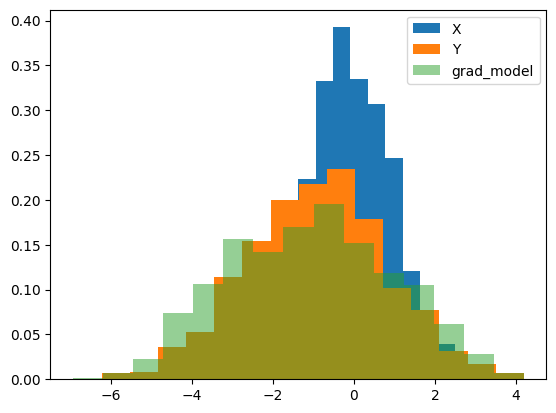

In [107]:
X = gaussian_dataset.X
Y = gaussian_dataset.Y
C = gaussian_dataset.C

#Calcul de la dérivée du PICNN

test = 50
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_model = model_init_f(x_i, c_i)

grad_model = torch.autograd.grad(outputs=output_model, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model[:, 0].detach().numpy(),  bins=15, label = 'grad_model', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)

plt.legend()

plt.show()

## __Makkuva__

In [108]:
ICNNf = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes)
ICNNg = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes)

# Load the state dictionary into ICNNf and ICNNg
ICNNf.load_state_dict(state_dict_init_f)
ICNNg.load_state_dict(state_dict_init_g)

<All keys matched successfully>

In [109]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

for epoch in range(25) :
    print('epoch :', epoch + 1)
    train_makkuva_epoch(ICNNf, ICNNg, dataloader)

epoch 0
loss_g: 2.8044862747192383, loss_f: -9.529709815979004
epoch 1
loss_g: 1.7789841890335083, loss_f: -6.503457069396973
epoch 2
loss_g: 1.1317534446716309, loss_f: -4.2651047706604
epoch 3
loss_g: 0.7582447528839111, loss_f: -2.6981658935546875
epoch 4
loss_g: 0.5344803929328918, loss_f: -1.6330351829528809
epoch 5
loss_g: 0.37174269556999207, loss_f: -1.0434820652008057
epoch 6
loss_g: 0.22975090146064758, loss_f: -0.7562378644943237
epoch 7
loss_g: 0.10852821171283722, loss_f: -0.5230954885482788
epoch 8
loss_g: 0.002075908239930868, loss_f: -0.36917731165885925
epoch 9
loss_g: -0.09401768445968628, loss_f: -0.2960885465145111
epoch 10
loss_g: -0.1688266396522522, loss_f: -0.25573617219924927
epoch 11
loss_g: -0.21580103039741516, loss_f: -0.22262297570705414
epoch 12
loss_g: -0.24114006757736206, loss_f: -0.18783803284168243
epoch 13
loss_g: -0.2470732182264328, loss_f: -0.14073976874351501
epoch 14
loss_g: -0.2355533391237259, loss_f: -0.0906907320022583
epoch 15
loss_g: -0.2

In [115]:
# filename_pth_f = 'ICNNf_TR.pth'
# filename_pth_g = 'ICNNg_TR.pth'

# torch.save(ICNNf.state_dict(), filename_pth_f)
# torch.save(ICNNg.state_dict(), filename_pth_g)

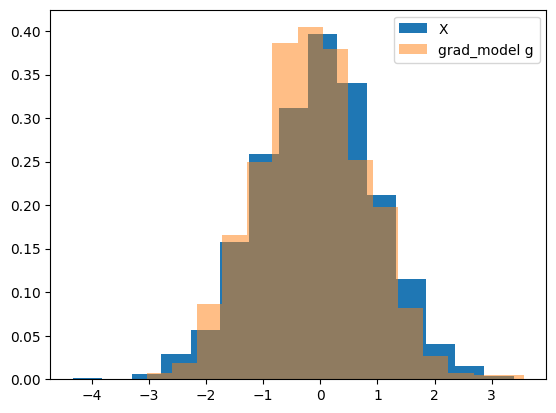

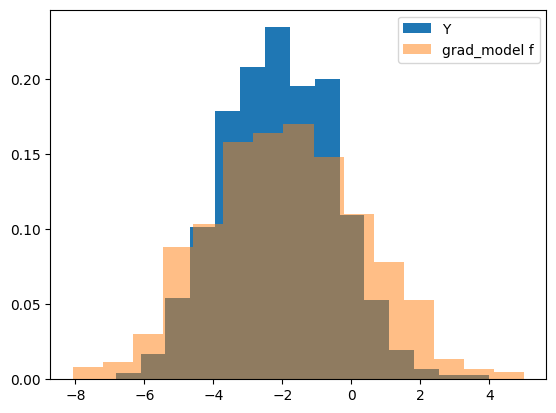

In [114]:
X = dataset.X
Y = dataset.Y
C = dataset.C

#Calcul de la dérivée du PICNN
test = 95
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
c_i.requires_grad_(True)    

output_model_f = ICNNf(x_i, c_i)
grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

output_model_g = ICNNg(y_i, c_i)
grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]


plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(grad_model_g[:, 0].detach().numpy(),  bins=15, label = 'grad_model g', density = True, alpha = 0.5)
plt.legend()
plt.show()

plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model_f[:, 0].detach().numpy(),  bins=15, label = 'grad_model f', density = True, alpha = 0.5)
plt.legend()
plt.show()